In [2]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import cluster

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from osgeo import gdal
import earthpy as et
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from shapely.geometry  import box
from tifffile import imsave
from rioxarray.merge import merge_arrays
from rasterio.plot import plotting_extent
import earthpy.plot as ep

In [49]:
nitrogen_path = os.path.join(et.io.HOME, 
                             'desktop', 
                             'earth-analytics', 
                             'python', 
                             'final-project', 
                             'nitrogen')

phosphorus_path = os.path.join(et.io.HOME, 
                             'desktop', 
                             'earth-analytics', 
                             'python', 
                             'final-project', 
                             'phosphorus')

nitrogen_to_mosaic = glob.glob(os.path.join(str(nitrogen_path), "*.tif"))

phosphorus_to_mosaic = glob.glob(os.path.join(str(phosphorus_path), "*.tif"))


rr_hu8_path = os.path.join(et.io.HOME,
                           'desktop',
                           'earth-analytics',
                           'python',
                           'final-project',
                           'polygon',
                           'RR_HU8-polygon.shp')

rr_hu8_boundary = gpd.read_file(rr_hu8_path)

streamstats_boundary_path = os.path.join(et.io.HOME, 
                                           'desktop',
                                           'earth-analytics',
                                           'python',
                                           'final-project', 
                                           'polygon2',
                                           'GlobalWatershed.shp')

streamstats_boundary = gpd.read_file(streamstats_boundary_path)




In [5]:

# function for clipping to shp and opening as a rasterio mosaic

def open_clean_bands(band_path,
                     crop_bound,
                     valid_range=None,
                     variable=None):
    # YOUR CODE HERE

    """Open and clean a single landsat band .

    Parameters
    -----------
    band_path:string A path to the array to be opened
    crop_bound:geopandas GeoDataFrame
    A geopandas dataframe to be used to crop the raster data using rioxarray clip().
    valid_range:tuple (optional)
     A tuple of min and max range of values for the data. Default = None

    Returns
    -----------
     band : xarray DataArray
        An xarray DataArray clipped to a crop boundary and masked if a range is given
    """

    crop_bound_box = [box(*crop_bound.bounds.loc[0])]

    try:
        band = rxr.open_rasterio(band_path,
                                 masked=True,
                                 variable=variable, 
                                 parse_coordinates=False).rio.clip(crop_bound_box,
                                                             #crs=crop_bound.crs,
                                                             all_touched=True,
                                                             from_disk=True).squeeze()
    except:
        raise ValueError(
            "Oops - I couldn't clip your data. This may be due to a crs error.")

    # Only mask the data to the valid range if a valid range tuple is provided
    if valid_range is not None:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    return band

In [6]:
# function for mosaic with GDAL library

def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    xMin = mapinfo[0]
    xMax = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    yMin = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    yMax = mapinfo[3]

    metadata['extent'] = (xMin,xMax,yMin,yMax)

    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()

    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(float)
        array[np.where(array==metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']

    elif metadata['bands'] > 1:    
        for i in range(1, dataset.RasterCount+1):
            band = dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(float)
            band[np.where(band==metadata['noDataValue'])]=np.nan
            #band = band/metadata['scaleFactor']
            array[...,i-1] = band

    return array, metadata

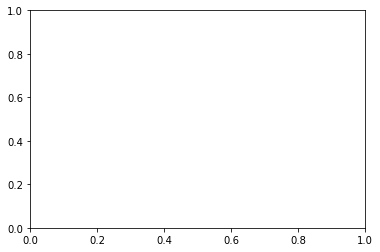

In [7]:
# plotting function

def plot_array(array,spatial_extent,colorlimit,ax=plt.gca(),title='',cmap_title='',colormap=''):
    plot = plt.imshow(array,extent=spatial_extent,clim=colorlimit); 
    cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
    cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90);

In [81]:
# change CRS of shapefiles to match rasters

rr_hu8_boundary_crs = rr_hu8_boundary.to_crs('EPSG:32610')

streamstats_boundary_crs = streamstats_boundary.to_crs('EPSG:32610')


In [82]:
# clip using RR_HU8.kml


# run function for clipping and cleaning nitrogen tifs (outputs a list of arrays)

nitrogen_tiles = []
for image, i in zip(nitrogen_to_mosaic, range(0,10)):
    tile = open_clean_bands(image,
                            rr_hu8_boundary_crs,
                            valid_range=(0,10000),
                            variable=None)
    nitrogen_tiles.append(tile)
    



# merge list of arrays for mosaic

merged_nitrogen = merge_arrays(nitrogen_tiles)
    



In [77]:
# clip using StreamStats


# run function for clipping and cleaning nitrogen tifs (outputs a list of arrays)

nitrogen_tiles_2 = []
for image in nitrogen_to_mosaic:
    tile = open_clean_bands(image,
                            streamstats_boundary_crs,
                            valid_range=(0,10000),
                            variable=None)
    nitrogen_tiles_2.append(tile)



# merge list of arrays for mosaic

merged_nitrogen_2 = merge_arrays(nitrogen_tiles_2)
    



ValueError: Oops - I couldn't clip your data. This may be due to a crs error.

In [10]:
# plot extent

nitrogen_extent = plotting_extent(merged_nitrogen[0],
                              merged_nitrogen.rio.transform())

In [15]:
# prep for GDAl plot

nitrogen_clipped_path = os.path.join(et.io.HOME, 
                                'desktop', 
                                'earth-analytics', 
                                'python', 
                                'final-project', 
                                'nitrogen', 
                                'clipped')

nitrogen_clipped_to_mosaic = glob.glob(os.path.join(str(nitrogen_clipped_path), "*.tif"))


nitrogen_string_clip = " ".join(nitrogen_clipped_to_mosaic)
phosphorus_string = " ".join(phosphorus_to_mosaic)

In [67]:
rr_hu8_path

'/Users/merielle/desktop/earth-analytics/python/final-project/polygon/RR_HU8-polygon.shp'

In [68]:



for image, i in zip(nitrogen_to_mosaic, range(0,10)):
    nitrogen_clip_gdal = gdal.Warp("/Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-clips-gdal/nitrogen-crop-gdal{}.tif".format(i), 
    image, 
    cutlineDSName='/Users/merielle/desktop/earth-analytics/python/final-project/polygon2/GlobalWatershed.shp',
    cropToCutline=True,
    dstNodata = 0)




nitrogen_string_clip = " ".join(nitrogen_clipped_to_mosaic)




In [84]:
# prep for GDAl plot


nitrogen_crop_gdal_path = os.path.join(et.io.HOME, 
                                'desktop', 
                                'earth-analytics', 
                                'python', 
                                'final-project', 
                                'nitrogen-clips-gdal')

nitrogen_crop_gdal_to_mosaic = glob.glob(os.path.join(str(nitrogen_crop_gdal_path), "*.tif"))


nitrogen_string_clip_gdal = " ".join(nitrogen_crop_gdal_to_mosaic)

nitrogen_crop_gdal_to_mosaic[0] = nitrogen_crop_gdal_to_mosaic[]

['/Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-clips-gdal/nitrogen-crop-gdal7.tif',
 '/Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-clips-gdal/nitrogen-crop-gdal6.tif',
 '/Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-clips-gdal/nitrogen-crop-gdal4.tif',
 '/Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-clips-gdal/nitrogen-crop-gdal5.tif',
 '/Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-clips-gdal/nitrogen-crop-gdal1.tif',
 '/Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-clips-gdal/nitrogen-crop-gdal0.tif',
 '/Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-clips-gdal/nitrogen-crop-gdal2.tif',
 '/Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-clips-gdal/nitrogen-crop-gdal3.tif',
 '/Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-clips-gdal/nitrogen-crop-gdal8.tif',
 '/Users/merielle/d

In [70]:

command_nitrogen = "gdal_merge.py -o /Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-mosaic-crop-gdal.tif -of gtiff " + nitrogen_string_clip_gdal
#command_phosphorus = "gdal_merge.py -o /Users/merielle/desktop/earth-analytics/python/final-project/phosphorus-mosaic.tif -of gtiff " + phosphorus_string

print(os.popen(command_nitrogen).read())
#print(os.popen(command_phosphorus).read())



0...10...20...30...40...50...60...70...80...90...100 - done.



In [18]:
nitrogen_mosaic_clipped_path = os.path.join(et.io.HOME, 
                                    'desktop', 
                                    'earth-analytics', 
                                    'python', 
                                    'final-project', 
                                    'nitrogen-mosaic-clipped.tif')


nitrogen_mosaic_clipped_path

'/Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-mosaic-clipped.tif'

In [71]:
# call raster2array

nitrogen_crop_array_gdal, nitrogen_crop_gdal_metadata = raster2array('/Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-mosaic-crop-gdal.tif')

#phosphorus_array, phosphorus_metadata = raster2array('/Users/merielle/desktop/earth-analytics/python/final-project/phosphorus-mosaic.tif')



In [21]:
#stacked_chemicals = np.dstack((nitrogen_array_one_layer, phosphorus_array_one_layer))

#stacked_chemicals.shape

In [345]:
import numpy.ma as ma

def clean_array_plot(xr_obj):
    # This function takes a single xarray object as an input and produces a
    # cleaned numpy array output for plotting
    # YOUR CODE HERE

    return ma.masked_array(xr_obj.values,  xr_obj.isnull())

In [346]:
nitrogen_clean = clean_array_plot(merged_nitrogen)

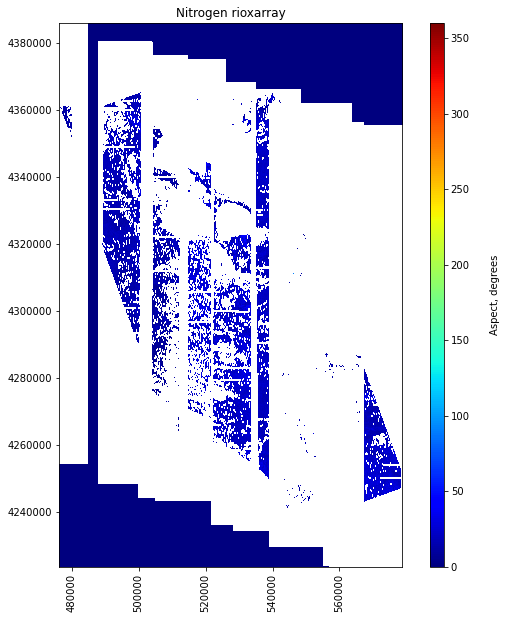

In [36]:
fig, ax = plt.subplots(figsize=(10,10))


plot_array(merged_nitrogen[0,:,:],
           nitrogen_extent,
           (0,360),
           title='Nitrogen rioxarray',
           cmap_title='Aspect, degrees',
           colormap='jet')



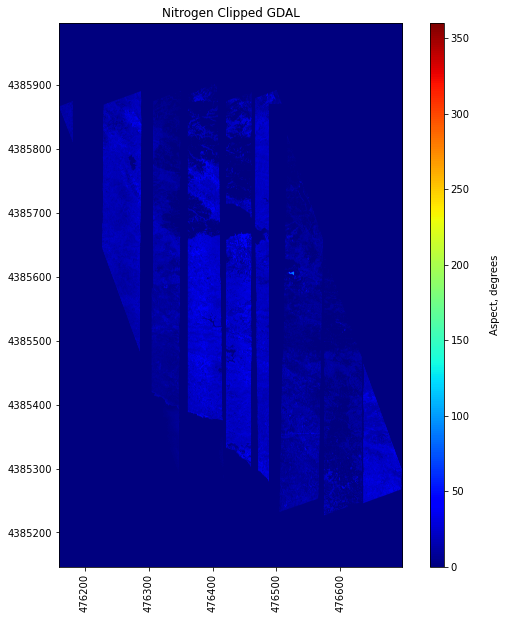

In [39]:
fig, ax = plt.subplots(figsize=(10,10))


plot_array(nitrogen_clipped_array[:,:,0],
           nitrogen_clipped_metadata['extent'],
           (0,360),
           title='Nitrogen Clipped GDAL',
           cmap_title='Aspect, degrees',
           colormap='jet')




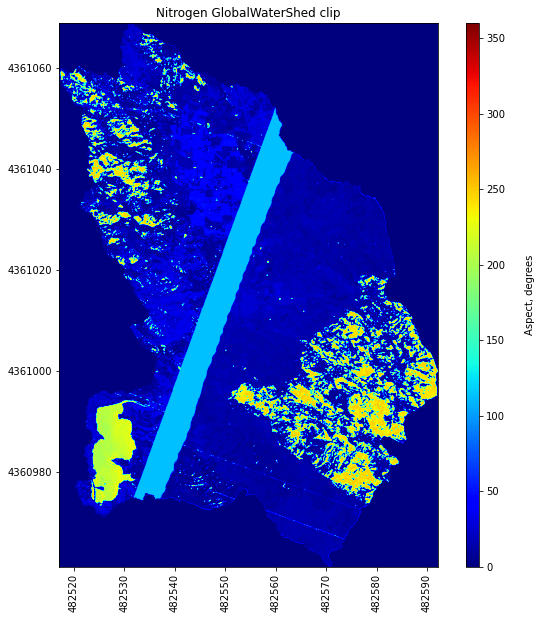

In [83]:
fig, ax = plt.subplots(figsize=(10,10))


plot_array(nitrogen_crop_array_gdal[:,:,0],
           nitrogen_crop_gdal_metadata['extent'],
           (0,360),
           title='Nitrogen GlobalWaterShed clip',
           cmap_title='Aspect, degrees',
           colormap='jet')

